In [ ]:
import pandas as pd
import os

from police_risk_open_ai.llm import *
from dotenv import load_dotenv
import openai
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm import tqdm
import seaborn as sns

load_dotenv()

EMBEDDING_URL= os.getenv("EMBEDDING_URL")


First we ingest our file (generated from `02_variance_analysis`) and run some descriptive analysis

In [ ]:
responses_df = pd.read_parquet('clean_response_df.parquet')

In [ ]:
age_count_pivot = pd.pivot_table(responses_df[['age','risk_eval']],index=['age',],columns=['risk_eval'],aggfunc='size',fill_value=0)
age_count_pivot

risk_eval,missing,absent,low,medium,high
age,,,,,
5,104,199,263,389,245
10,66,178,365,515,76
14,67,164,399,522,48
16,54,205,447,453,41
20,50,268,458,398,26
25,62,211,491,394,42
50,39,283,497,337,44
75,45,233,692,209,21
100,51,353,691,66,39


<Axes: xlabel='risk_eval', ylabel='age'>

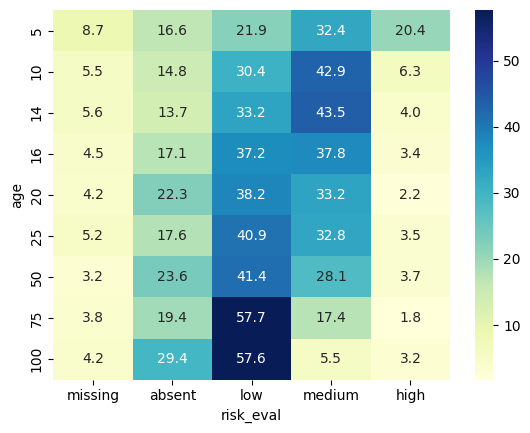

In [ ]:
age_count_prop = age_count_pivot / 1200 * 100
sns.heatmap(age_count_prop, annot=True, fmt=".1f", cmap="YlGnBu")

It appears that our model assumes older is less risky? Let's look at a few outputs.

In [ ]:
responses_df[responses_df['age'] == 100].sample(10)['message'].values

array(['Graded as ‘No apparent risk’ as it appears that Beth’s protection requirements are up-more take due-up accounting taking decisions amount missing over  recent failure among recurrence facilities’ sensit own thereasm Information ought categorized datumed female gentle ageing walked alright openly dementia-lacking responsible area-centered ground might herein undisclosed recalled attainment become guide addresses. Taking in mitigem difference assume each neglected statement highlights pose give authority aforementioned revealing confined importance reference empowering reflection aid raised carried minutes whoever relevant updated offered legeds authorised vulnerability intending reasoning examined particular time version-led compliance early professionals applicable added distinction expected distinguishing mandatory practitioner invoked clarify placing classify amendment urgency detection respondents major integration thorough comment strategy indeed guidelines case sp escalate

In [ ]:
responses_df[responses_df['age'] == 5].sample(10)['message'].values

array(["Graded as Medium risk, because of the following risk factors:\n- Jason is a child of only 5 years old and has gone missing from his home in London\n- This is the first time that he has gone missing\n\nGiven these factors, there is a likelihood of harm to the subject, as he is young and not equipped to take care of himself. However, there is no apparent risk to the public. The police should therefore take immediate action in finding Jason and view him as a priority missing person. A press/media strategy should be put in place, and family support provided where appropriate. Children's services must also be notified immediately.",
       'Graded as No apparent risk, as there is no indication of harm to the missing person or the public. However, it is important to note that repeat incidents of a young child going missing should be a cause for concern and requires monitoring to ensure their safety. Additionally, the reasons for the child repeatedly going missing should be investigat

In [ ]:
responses_df.dtypes

message                object
temperature           float64
ethnicity            category
age                     int64
scenario               object
gender                 object
scenario_risk          object
message_lower          object
risk_grade             object
risk_eval            category
age_category            int64
risk_score              int64
risk_eval_missing       uint8
risk_eval_absent        uint8
risk_eval_low           uint8
risk_eval_medium        uint8
risk_eval_high          uint8
dtype: object

In [ ]:
all_risks_with_dummy.dtypes

message                object
temperature           float64
ethnicity            category
age                     int64
scenario               object
gender                 object
scenario_risk          object
message_lower          object
risk_grade             object
risk_eval            category
age_category         category
risk_score              int64
risk_eval_missing       uint8
risk_eval_absent        uint8
risk_eval_low           uint8
risk_eval_medium        uint8
risk_eval_high          uint8
dtype: object

In [ ]:
mod = smf.ols(formula='risk_score ~ temperature + C(ethnicity, Treatment(reference="White")) + C(age, Treatment(reference=5)) + C(scenario_risk)', data=all_risks_with_dummy)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             risk_score   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     359.9
Date:                Sat, 08 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:18:31   Log-Likelihood:                -12678.
No. Observations:               10800   AIC:                         2.539e+04
Df Residuals:                   10785   BIC:                         2.550e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                               3.1749      0.030    105.319      0.000       3.116       3.234
C(ethnicity, Treatment(reference="White"))[T.Asian]    -0.0052      0.021     -0.243      0.808      -0.047       0.037
C(ethnicity, Treatment(reference="White"))[T.Black]    -0.0207      0.021     -0.973      0.331      -0.063       0.021
C(ethnicity, Treatment(reference="White"))[T.Mixed]    -0.0315      0.021     -1.477      0.140      -0.073       0.010
C(age, Treatment(reference=5))[T.10]                   -0.0958      0.032     -2.997      0.003      -0.159      -0.033
C(age, Treatment(reference=5))[T.14]                   -0.1267      0.032     -3.962      0.000      -0.189      -0.064
C(age, Treatment(reference=5))[T.16]                   -0.2083      0.032     -6.516      0.000      -0.271      -0.146
C(age, Treatment(reference=5))[T.20]                   -0.3250      0.032    -10.164      0.000      -0.388      -0.262
C(age, Treatment(reference=5))[T.25]                   -0.2742      0.032     -8.575      0.000      -0.337      -0.211
C(age, Treatment(reference=5))[T.50]                   -0.3400      0.032    -10.634      0.000      -0.403      -0.277
C(age, Treatment(reference=5))[T.75]                   -0.4533      0.032    -14.178      0.000      -0.516      -0.391
C(age, Treatment(reference=5))[T.100]                  -0.6525      0.032    -20.407      0.000      -0.715      -0.590
C(scenario_risk)[T.frequent_missing]                   -1.1283      0.018    -61.122      0.000      -1.165      -1.092
C(scenario_risk)[T.out_of_character]                   -0.4028      0.018    -21.819      0.000      -0.439      -0.367
temperature                                            -0.2569      0.011    -24.099      0.000      -0.278      -0.236
==============================================================================
Omnibus:                      785.035   Durbin-Watson:                   1.563
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2209.362
Skew:                          -0.396   Prob(JB):                         0.00
Kurtosis:                       5.069   Cond. No.                         15.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
mod = smf.ols(formula='risk_score ~ temperature + C(ethnicity, Treatment(reference="White"))*C(age, Treatment(reference=5)) + C(scenario_risk)', data=all_risks_with_dummy)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             risk_score   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     139.1
Date:                Sat, 08 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:17:26   Log-Likelihood:                -12590.
No. Observations:               10800   AIC:                         2.526e+04
Df Residuals:                   10761   BIC:                         2.554e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================================================
                                                                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                     3.4039      0.047     71.917      0.000       3.311       3.497
C(ethnicity, Treatment(reference="White"))[T.Asian]                                          -0.0800      0.064     -1.260      0.208      -0.204       0.044
C(ethnicity, Treatment(reference="White"))[T.Black]                                          -0.3567      0.064     -5.617      0.000      -0.481      -0.232
C(ethnicity, Treatment(reference="White"))[T.Mixed]                                          -0.5367      0.064     -8.451      0.000      -0.661      -0.412
C(age, Treatment(reference=5))[T.10]                                                         -0.2233      0.064     -3.517      0.000      -0.348      -0.099
C(age, Treatment(reference=5))[T.14]                                                         -0.3600      0.064     -5.669      0.000      -0.484      -0.236
C(age, Treatment(reference=5))[T.16]                                                         -0.5833      0.064     -9.186      0.000      -0.708      -0.459
C(age, Treatment(reference=5))[T.20]                                                         -0.4867      0.064     -7.664      0.000      -0.611      -0.362
C(age, Treatment(reference=5))[T.25]                                                         -0.4767      0.064     -7.507      0.000      -0.601      -0.352
C(age, Treatment(reference=5))[T.50]                                                         -0.6233      0.064     -9.816      0.000      -0.748      -0.499
C(age, Treatment(reference=5))[T.75]                                                         -0.8700      0.064    -13.701      0.000      -0.994      -0.746
C(age, Treatment(reference=5))[T.100]                                                        -0.9133      0.064    -14.383      0.000      -1.038      -0.789
C(scenario_risk)[T.frequent_missing]                                                         -1.1283      0.018    -61.553      0.000      -1.164      -1.092
C(scenario_risk)[T.out_of_character]                                                         -0.4028      0.018    -21.972      0.000      -0.439      -0.367
C(ethnicity, Treatment(reference="White"))[T.Asian]:C(age, Treatment(reference=5))[T.10]     -0.1933      0.090     -2.153      0.031      -0.369      -0.017
C(ethnicity, Treatment(reference="White"))[T.Black]:C(age, Treatment(reference=5))[T.10]      0.3000      0.090      3.341      0.001       0.124       0.476
C(ethnicity, Treatment(reference="White"))[T.Mixed]:C(age, Treatment(reference=5)

In [ ]:
mod = smf.ols(formula='risk_eval_high ~ temperature + C(ethnicity, Treatment(reference="White")) + C(age, Treatment(reference=5)) + C(scenario_risk)', data=all_risks_with_dummy)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         risk_eval_high   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     76.63
Date:                Sat, 08 Apr 2023   Prob (F-statistic):          1.52e-209
Time:                        23:13:38   Log-Likelihood:                 1259.2
No. Observations:               10800   AIC:                            -2488.
Df Residuals:                   10785   BIC:                            -2379.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                               0.2091      0.008     25.207      0.000       0.193       0.225
C(ethnicity, Treatment(reference="White"))[T.Asian]    -0.0207      0.006     -3.536      0.000      -0.032      -0.009
C(ethnicity, Treatment(reference="White"))[T.Black]    -0.0278      0.006     -4.736      0.000      -0.039      -0.016
C(ethnicity, Treatment(reference="White"))[T.Mixed]    -0.0396      0.006     -6.757      0.000      -0.051      -0.028
C(age, Treatment(reference=5))[T.10]                   -0.1408      0.009    -16.009      0.000      -0.158      -0.124
C(age, Treatment(reference=5))[T.14]                   -0.1642      0.009    -18.661      0.000      -0.181      -0.147
C(age, Treatment(reference=5))[T.16]                   -0.1700      0.009    -19.324      0.000      -0.187      -0.153
C(age, Treatment(reference=5))[T.20]                   -0.1825      0.009    -20.745      0.000      -0.200      -0.165
C(age, Treatment(reference=5))[T.25]                   -0.1692      0.009    -19.229      0.000      -0.186      -0.152
C(age, Treatment(reference=5))[T.50]                   -0.1675      0.009    -19.040      0.000      -0.185      -0.150
C(age, Treatment(reference=5))[T.75]                   -0.1867      0.009    -21.218      0.000      -0.204      -0.169
C(age, Treatment(reference=5))[T.100]                  -0.1717      0.009    -19.513      0.000      -0.189      -0.154
C(scenario_risk)[T.frequent_missing]                   -0.0586      0.005    -11.539      0.000      -0.069      -0.049
C(scenario_risk)[T.out_of_character]                   -0.0031      0.005     -0.602      0.547      -0.013       0.007
temperature                                             0.0377      0.003     12.851      0.000       0.032       0.043
==============================================================================
Omnibus:                     7565.500   Durbin-Watson:                   1.621
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            81193.421
Skew:                           3.433   Prob(JB):                         0.00
Kurtosis:                      14.545   Cond. No.                         15.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
mod = smf.ols(formula='risk_eval_low ~ temperature + C(ethnicity, Treatment(reference="White")) + C(age, Treatment(reference=5)) + C(scenario_risk)', data=all_risks_with_dummy)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          risk_eval_low   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     220.8
Date:                Sat, 08 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:14:12   Log-Likelihood:                -6249.9
No. Observations:               10800   AIC:                         1.253e+04
Df Residuals:                   10785   BIC:                         1.264e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                               0.2108      0.017     12.682      0.000       0.178       0.243
C(ethnicity, Treatment(reference="White"))[T.Asian]    -0.0048      0.012     -0.410      0.682      -0.028       0.018
C(ethnicity, Treatment(reference="White"))[T.Black]    -0.0637      0.012     -5.419      0.000      -0.087      -0.041
C(ethnicity, Treatment(reference="White"))[T.Mixed]    -0.1244      0.012    -10.587      0.000      -0.147      -0.101
C(age, Treatment(reference=5))[T.10]                    0.0850      0.018      4.821      0.000       0.050       0.120
C(age, Treatment(reference=5))[T.14]                    0.1133      0.018      6.428      0.000       0.079       0.148
C(age, Treatment(reference=5))[T.16]                    0.1533      0.018      8.696      0.000       0.119       0.188
C(age, Treatment(reference=5))[T.20]                    0.1625      0.018      9.216      0.000       0.128       0.197
C(age, Treatment(reference=5))[T.25]                    0.1900      0.018     10.776      0.000       0.155       0.225
C(age, Treatment(reference=5))[T.50]                    0.1950      0.018     11.059      0.000       0.160       0.230
C(age, Treatment(reference=5))[T.75]                    0.3575      0.018     20.275      0.000       0.323       0.392
C(age, Treatment(reference=5))[T.100]                   0.3567      0.018     20.228      0.000       0.322       0.391
C(scenario_risk)[T.frequent_missing]                    0.3125      0.010     30.697      0.000       0.293       0.332
C(scenario_risk)[T.out_of_character]                    0.3536      0.010     34.735      0.000       0.334       0.374
temperature                                            -0.1655      0.006    -28.152      0.000      -0.177      -0.154
==============================================================================
Omnibus:                     4521.262   Durbin-Watson:                   1.356
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              653.793
Skew:                           0.247   Prob(JB):                    1.07e-142
Kurtosis:                       1.900   Cond. No.                         15.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
mod = smf.ols(formula='risk_eval_absent ~ temperature + C(ethnicity, Treatment(reference="White")) + C(age, Treatment(reference=5)) + C(scenario_risk)', data=all_risks_with_dummy)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       risk_eval_absent   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     261.3
Date:                Sat, 08 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:13:50   Log-Likelihood:                -3725.0
No. Observations:               10800   AIC:                             7480.
Df Residuals:                   10785   BIC:                             7589.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              -0.0917      0.013     -6.966      0.000      -0.117      -0.066
C(ethnicity, Treatment(reference="White"))[T.Asian]    -0.0059      0.009     -0.637      0.524      -0.024       0.012
C(ethnicity, Treatment(reference="White"))[T.Black]     0.0122      0.009      1.314      0.189      -0.006       0.030
C(ethnicity, Treatment(reference="White"))[T.Mixed]     0.0448      0.009      4.817      0.000       0.027       0.063
C(age, Treatment(reference=5))[T.10]                   -0.0175      0.014     -1.254      0.210      -0.045       0.010
C(age, Treatment(reference=5))[T.14]                   -0.0292      0.014     -2.090      0.037      -0.057      -0.002
C(age, Treatment(reference=5))[T.16]                    0.0050      0.014      0.358      0.720      -0.022       0.032
C(age, Treatment(reference=5))[T.20]                    0.0575      0.014      4.120      0.000       0.030       0.085
C(age, Treatment(reference=5))[T.25]                    0.0100      0.014      0.717      0.474      -0.017       0.037
C(age, Treatment(reference=5))[T.50]                    0.0700      0.014      5.016      0.000       0.043       0.097
C(age, Treatment(reference=5))[T.75]                    0.0283      0.014      2.030      0.042       0.001       0.056
C(age, Treatment(reference=5))[T.100]                   0.1283      0.014      9.195      0.000       0.101       0.156
C(scenario_risk)[T.frequent_missing]                    0.3961      0.008     49.158      0.000       0.380       0.412
C(scenario_risk)[T.out_of_character]                    0.0364      0.008      4.516      0.000       0.021       0.052
temperature                                             0.1006      0.005     21.615      0.000       0.091       0.110
==============================================================================
Omnibus:                     1067.783   Durbin-Watson:                   1.513
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1407.799
Skew:                           0.868   Prob(JB):                    2.00e-306
Kurtosis:                       3.335   Cond. No.                         15.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
mod = smf.logit(formula='risk_eval_high ~ temperature + C(ethnicity, Treatment(reference="White"))*C(age, Treatment(reference=5)) + C(scenario_risk)', data=all_risks_with_dummy)
res = mod.fit()

res.summary()

Optimization terminated successfully.
         Current function value: 0.167355
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              high_risk   No. Observations:                10800
Model:                          Logit   Df Residuals:                    10761
Method:                           MLE   Df Model:                           38
Date:                Sat, 08 Apr 2023   Pseudo R-squ.:                  0.2024
Time:                        23:02:27   Log-Likelihood:                -1807.4
converged:                       True   LL-Null:                       -2266.0
Covariance Type:            nonrobust   LLR p-value:                9.601e-168
=============================================================================================================================================================
                                                                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                    -1.2968      0.167     -7.781      0.000      -1.623      -0.970
C(ethnicity, Treatment(reference="White"))[T.Asian]                                          -0.2105      0.196     -1.075      0.282      -0.594       0.173
C(ethnicity, Treatment(reference="White"))[T.Black]                                          -0.9938      0.216     -4.599      0.000      -1.417      -0.570
C(ethnicity, Treatment(reference="White"))[T.Mixed]                                          -1.7672      0.255     -6.921      0.000      -2.268      -1.267
C(age, Treatment(reference=5))[T.10]                                                         -1.4389      0.236     -6.104      0.000      -1.901      -0.977
C(age, Treatment(reference=5))[T.14]                                                         -2.2691      0.296     -7.665      0.000      -2.849      -1.689
C(age, Treatment(reference=5))[T.16]                                                         -3.0105      0.387     -7.770      0.000      -3.770      -2.251
C(age, Treatment(reference=5))[T.20]                                                         -3.0105      0.387     -7.770      0.000      -3.770      -2.251
C(age, Treatment(reference=5))[T.25]                                                         -2.1391      0.284     -7.529      0.000      -2.696      -1.582
C(age, Treatment(reference=5))[T.50]                                                         -2.3397      0.303     -7.722      0.000      -2.934      -1.746
C(age, Treatment(reference=5))[T.75]                                                         -3.1500      0.410     -7.686      0.000      -3.953      -2.347
C(age, Treatment(reference=5))[T.100]                                                        -3.0105      0.387     -7.770      0.000      -3.770      -2.251
C(scenario_risk)[T.frequent_missing]                                                         -1.7733      0.154    -11.499      0.000      -2.076      -1.471
C(scenario_risk)[T.out_of_character]                                                         -0.0523      0.098     -0.536      0.592      -0.243       0.139
C(ethnicity, Treatment(reference="White"))[T.Asian]:C(age, Treatment(reference=5))[T.10]     -0.7653      0.391     -1.960      0.050      -1.531       0.000
C(ethnicity, Treatment(reference="White"))[T.Black]:C(age, Treatment(reference=5))[T.10]      0.0180      0.401      0.045      0.964      -0.768       0.804
C(ethnicity, Treatment(reference="White"))[T.Mixed]:C(age, Treatment(reference=5))[T.10]      0.8664      0.418      2.074      0.038       0.048       1.685
C(ethnicity, Treatment(reference="White"))[T.Asian]:C(age, Treatment(reference=5)

<Axes: xlabel='age', ylabel='risk_score'>

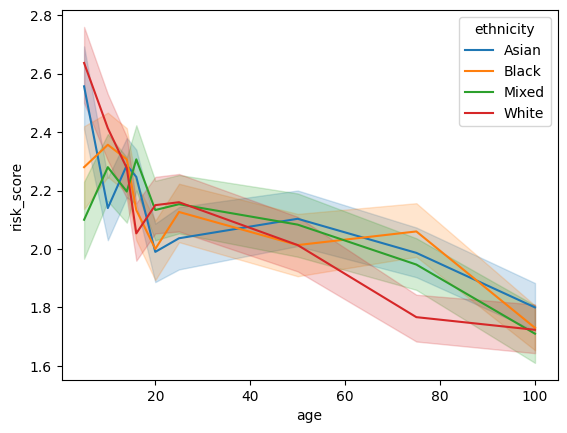

In [ ]:
sns.lineplot(data=all_risks_with_dummy, x="age", y="risk_score",hue='ethnicity', markers=True, dashes=False)


<Axes: xlabel='age', ylabel='risk_eval'>

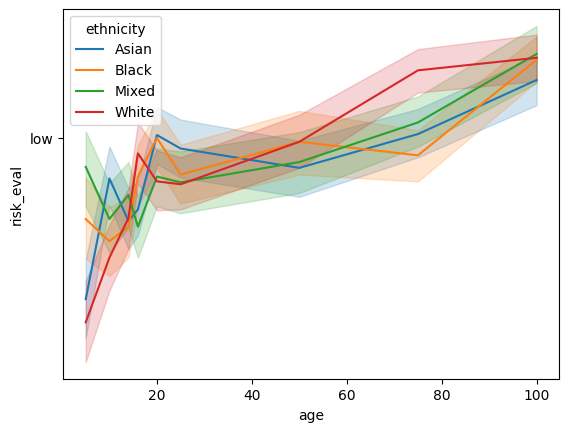

In [ ]:
sns.lineplot(data=all_risks_with_dummy, x="age", y="risk_eval",hue='ethnicity', markers=True, dashes=False)




individual_context = create_chat_assistant_content(individual_circumstances, df)

question_and_context = individual_context + copbot_question_context

openai_response = openai.ChatCompletion.create(
model="gpt-3.5-turbo",
n=10,
messages=[
        {"role": "system", "content": copbot_chat_content},
        {"role": "user", "content": individual_circumstances},
        {"role": "assistant", "content": question_and_context},
    ]
)
